<a href="https://colab.research.google.com/github/harishanmugaraja/harishanmugaraja.github.io/blob/master/Copy_of_cmsc472_spring_23_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Instructions

1. Enter your Name, UID and Link to Google Drive in the provided space.
2. Submit the assignment to Gradescope.

Intermediate Submission Deadline: March 23, 5:00pm

Final Submission Deadline: March 27, 5:00pm

As before, submit your challenge file to ELMS.

Name:  **Hariharmano Shanmugaraja**  
UID:  **117254815**

Link to Google Drive : **https://colab.research.google.com/drive/1OsPmwCyiTVT_rDT_AXpca_S45wy-ysbo?usp=sharing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

import random

## Dataset and Preprocessing

For this assignment, we will use the following dataset, which contains images of animals and such with segmentations.

In [ ]:
#For deleting the dataset
# !rm -r SegmentationDataset/

In [ ]:
#Use this to download if not using colab
download_link='https://drive.google.com/file/d/1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn/view?usp=sharing'

#If using colab dataset can be downloaded using this command
!gdown --id 1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
!unzip --qq SegmentationDataset.zip

In [ ]:
%matplotlib inline
import cv2
import os
import torch.utils.data as data
from torchvision import transforms
import _pickle as pickle
import torchvision.models as models
import glob

current_directory = os.getcwd()
msrc_directory = current_directory + '/SegmentationDataset'

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """

    plt.figure()
    if(im.shape[2]==1):
        plt.imshow(np.squeeze(im),cmap='gray')
    elif cv2:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)
    

In [ ]:
# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

background_classes=["void","grass","sky"]
background_colors=[]
for i in range(len(SEG_LABELS_LIST_v1)):
    if SEG_LABELS_LIST_v1[i]["name"] in background_classes:
        background_colors.append(SEG_LABELS_LIST_v1[i]["rgb_values"])



def get_binary_seg(bgr_seg):
    rgb_seg=bgr_seg#[:,:,::-1]#reverse order of channels from bgr to rgb
    shape_rgb=rgb_seg.shape
    binary_shape=(shape_rgb[0],shape_rgb[1],1)

    binary_map=np.ones( binary_shape )
    for background_color in background_colors:
        binary_map[(rgb_seg==background_color).all(2)]=0
    
    return binary_map

Here are some examples.

<class 'numpy.ndarray'>
(213, 320, 3)


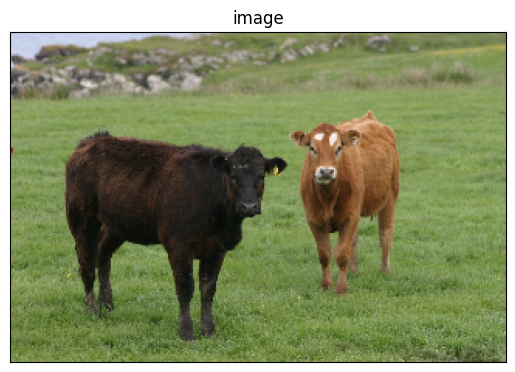

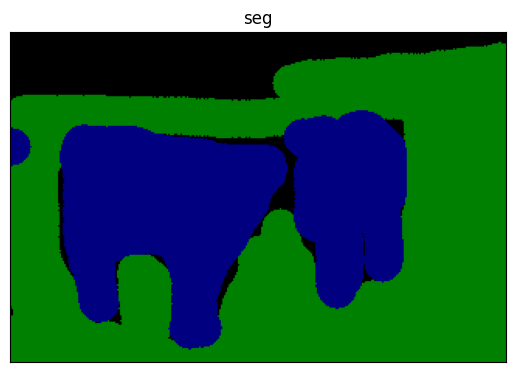

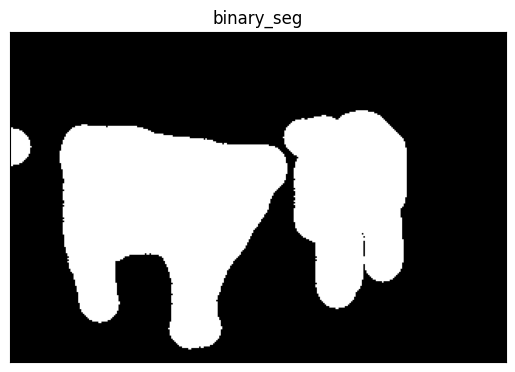

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('SegmentationDataset/train/1_19_s.bmp')
seg_sample = cv2.imread('SegmentationDataset/train/1_19_s_GT.bmp') 
print(type(seg_sample))
print(seg_sample.shape)
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
plot_image(get_binary_seg(seg_sample), 'binary_seg')

Here we provide you with a Dataset and dataloaders.

---



In [ ]:
class SegmentationData(data.Dataset):
    #168:48:24 split
    def __init__(self, img_transform, mask_transform, mode='train'):
        if mode not in ['train','test','val']:
            raise ValueError('Invalid Split %s' % mode)
        self.mode = mode
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img_list_train_val = [x.split('.')[-2].split('/')[-1][:-3] for x in glob.glob(msrc_directory+'/train/*') if 'GT' in x]
        self.img_list_train_val.sort()
        self.img_list_test = [x.split('.')[-2].split('/')[-1] for x in glob.glob(msrc_directory+'/test/*')]
        self.img_list_test.sort()

        self.x={}
        self.y={}
        self.x['train'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.y['train'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.x['val'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.y['val'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.x['test'] = ['%s/%s.bmp' %(msrc_directory+'/test',x) for x in self.img_list_test]

    def __len__(self):
        return len(self.x[self.mode])

    def __getitem__(self, index):
      if self.mode in ['train', 'val']:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          mask = get_binary_seg(np.array(Image.open(self.y[self.mode][index]).convert('RGB')))#.astype(np.int)
          mask = np.squeeze(mask.astype(np.uint8), axis=2)*255
          mask = Image.fromarray(mask)
          tensor_img = self.img_transform(img)
          tensor_mask = self.mask_transform(mask)
          if self.mode == 'train':
            if random.random() > 0.5:
              tensor_img = transforms.RandomHorizontalFlip(1.0)(tensor_img)
              tensor_mask = transforms.RandomHorizontalFlip(1.0)(tensor_mask)
          return tensor_img,tensor_mask
      else:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          tensor_img = self.img_transform(img)
          return tensor_img


img_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
mask_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='val')
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)
test_set = SegmentationData(img_transform=img_transform, mask_transform=mask_transform, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=24, shuffle=False)

For convenience, here's an example of how to use these dataloaders.

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
<class 'torch.Tensor'>
torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
torch.Size([24, 3, 256, 256])


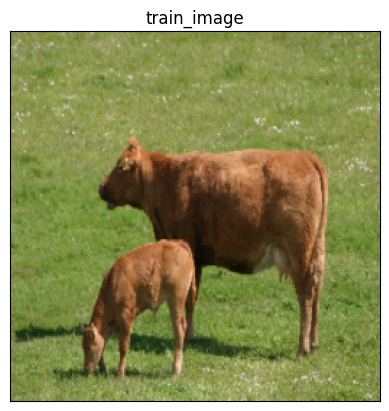

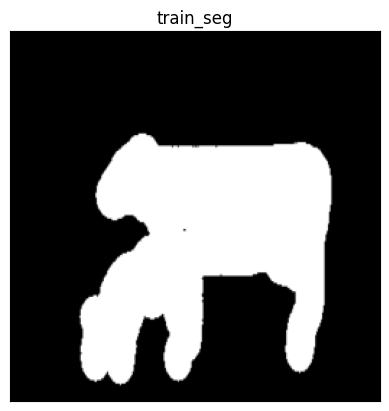

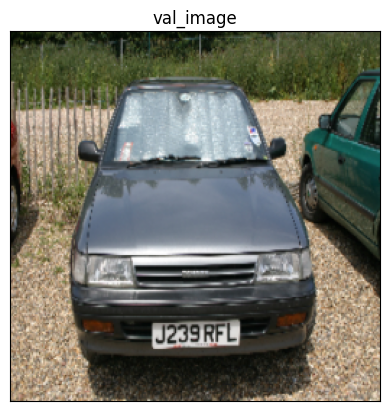

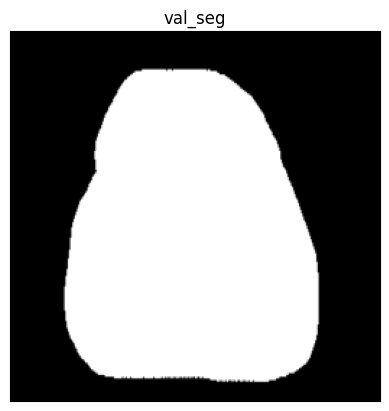

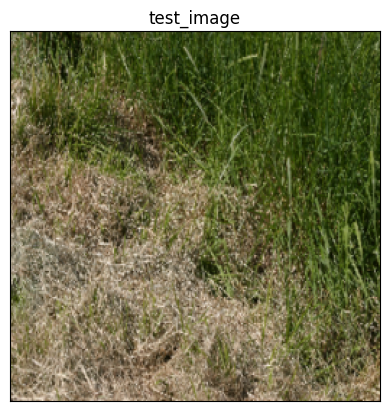

In [31]:
def compute_per_pixel_acc(outputs, labels):
  rounded_outputs = torch.where(outputs > 0.5, 1., 0.)
  return (rounded_outputs==labels).sum() / (np.prod(labels.shape))
  

input,labels = next(iter(train_dataloader))
print(input.shape,labels.shape)
print(type(input[2]))
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'train_image', cv2=False)
plot_image(mask, 'train_seg')

input,labels = next(iter(val_dataloader))
print(input.shape,labels.shape)
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'val_image', cv2=False)
plot_image(mask, 'val_seg')

input = next(iter(test_dataloader))
print(input.shape)
img = input[1].numpy().transpose(1, 2, 0)
plot_image(img * 0.5 + 0.5, 'test_image', cv2=False)

def draw_image(img_arr):
  img = img_arr.cpu().detach().numpy().transpose(1, 2, 0)
  plot_image(img * 0.5 + 0.5, 'img', cv2=False)

In [ ]:
print(mask.max())
print(mask.min())
print(mask.shape)

1.0
0.0
(256, 256, 1)


## 1. Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to perform these segmentations, where we need to distinguish foreground from background, where the class of interest is considered foreground.

###  U-Net

<img src="https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png" style="width:650px;height:400px;">

A U-Net is an end-to-end segmentation network that should work reasonably well in this low data setting. It will take an image, progressively convolve it to a collection of many small feature maps, and then progressively up-convolve the maps while combining with crops from the previous layers. The figure provided gives an excellent example of a baseline U-Net that you can use as a starting point.

For these operations, use ```nn.Conv2d```, ```torch.cat```, and ```nn.ConvTranspose2d```, ```nn.MaxPool2d```. You may find it useful to use ```nn.BatchNorm2d``` as well.

Note that you can experiment with different channel sizes. Try to start with something smaller than 112, like 16.

Let's now implement those the model!

In [ ]:
#methodology adapted from https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

class conv_block(nn.Module):
  def __init__(self, input_channels, out_channels, kernel_size=3):
    super(conv_block, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size, padding='same')
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
    self.batch_norm2 = nn.BatchNorm2d(out_channels)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.relu(x)
    return x

class conv_block_with_dropout(nn.Module):
  def __init__(self, input_channels, out_channels, kernel_size=3, zero_out_prob=0.5):
    super(conv_block_with_dropout, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size, padding='same')
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
    self.batch_norm2 = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout(zero_out_prob)
  
  def forward(self, x):
    x = self.dropout(x)
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.relu(x)
    return x

class encoder_block(nn.Module):
  def __init__(self, input_channels, out_channels):
    super(encoder_block, self).__init__()
    self.conv_layers = conv_block(input_channels, out_channels)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, x):
    output = self.conv_layers(x)
    pooled_output = self.pool(output)
    return output, pooled_output #output will be used for skip connections

class decoder_block(nn.Module):
  def __init__(self, input_channels, out_channels):
    super(decoder_block, self).__init__()
    self.up = nn.ConvTranspose2d(input_channels, input_channels, kernel_size=2, stride=2, padding = 0)
    self.conv_layers = conv_block_with_dropout(input_channels * 2, out_channels)

  def forward(self, x, skip):
    up = self.up(x)
    catted = torch.cat([up,skip], axis=1)
    output = self.conv_layers(catted)
    return output

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.base_channels = 128
    self.e1 = encoder_block(3, self.base_channels)
    self.e2 = encoder_block(self.base_channels, self.base_channels*2)
    self.e3 = encoder_block(self.base_channels*2, self.base_channels*4)
    self.c = conv_block(self.base_channels * 4, self.base_channels * 4)
    self.d1 = decoder_block(self.base_channels * 4, self.base_channels * 2)
    self.d2 = decoder_block(self.base_channels * 2, self.base_channels)
    self.d3 = decoder_block(self.base_channels, self.base_channels)
    self.outputs = nn.Conv2d(self.base_channels, 1, kernel_size=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    s1, p1 = self.e1(input)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    c = self.c(p3)
    # print("c dims", c.shape)
    # print("s3 dims", s3.shape)
    d1 = self.d1(c,s3)
    # print(d1.shape)
    d2 = self.d2(d1, s2)
    # print(d2.shape)
    d3 = self.d3(d2, s1)
    c2 = self.outputs(d3)
    outputs = self.sigmoid(c2)
    return outputs

## 2. Defining the for loop for train and validation phase

### In each the phases certain things one has to be careful of:

- Training Phase:
  - Make sure the model is in train mode. That is ensured by `model.train()`

  - While looping over instances of a batch, make sure the graidents are always set to zero before calling the backward function. That's done by `optim.zero_grad()`. If this is not done, the gradients get accumulated.

  - Call the backward function on the loss by `loss.backward()` so that the loss get back propagated.

  - Call the step function of the optimiser to update the weights of the network. This is done by `optim.step()`

- Validation/Testing Phase
  - Make sure your model is in eval mode. This makes the model deterministic rather than probabilistic. This is ensured by `model.eval()`
  - As we don't need any gradients doing our validation/ testing phase, we can esnure that they are not calculated by defining a block with `torch.no_grad()`

In [ ]:
model = UNet()
model = model.cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
train_acc_per_epoch = []
train_loss_per_epoch = []
val_acc_per_epoch = []
val_loss_per_epoch = []
val_loss_per_batch_across_epochs = []
train_loss_per_batch_across_epochs = []
# Run your training / validation loops
num_epochs = 100
for epoch in range(num_epochs):
  model.train()

  train_acc_per_batch = []
  train_loss_per_batch = []
  val_acc_per_batch = []
  val_loss_per_batch = []

  for idx1, batch in enumerate(train_dataloader):
    inputs, labels = batch
    inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    train_loss_per_batch.append(loss.item())
    train_acc_per_batch.append(compute_per_pixel_acc(outputs, labels).item())
    loss.backward()
    optimizer.step()

  train_loss_per_epoch.append(np.mean(train_loss_per_batch))
  train_acc_per_epoch.append(np.mean(train_acc_per_batch))

  train_loss_per_batch_across_epochs.extend(train_acc_per_batch)
  
  with torch.no_grad():
    model.eval()
    for idx1, batch in enumerate(val_dataloader):
      inputs, labels = batch
      inputs, labels = inputs.cuda(), labels.cuda()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss_per_batch.append(loss.item())
      val_acc_per_batch.append(compute_per_pixel_acc(outputs, labels).item())
  
  val_loss_per_epoch.append(np.mean(val_loss_per_batch))
  val_acc_per_epoch.append(np.mean(val_acc_per_batch))

  val_loss_per_batch_across_epochs.extend(val_loss_per_batch)

  print("train_loss: {}, train_acc: {}, val_loss: {}, val_acc: {}".format(np.mean(train_loss_per_batch), np.mean(train_acc_per_epoch), np.mean(val_loss_per_batch), np.mean(val_acc_per_epoch)))

train_loss: 0.6777995391325518, train_acc: 0.613663066517223, val_loss: 57.84514872233073, val_acc: 0.3984537124633789
train_loss: 0.5082387897101316, train_acc: 0.6792803677645597, val_loss: 19.917885462443035, val_acc: 0.40521160761515296
train_loss: 0.5114482289010828, train_acc: 0.7023258787212949, val_loss: 1.7073150475819905, val_acc: 0.4584473503960503
train_loss: 0.4680988707325675, train_acc: 0.7185879837382922, val_loss: 0.7223365505536398, val_acc: 0.4921957651774088
train_loss: 0.4484533044424924, train_acc: 0.7320571899414061, val_loss: 0.7225217620531718, val_acc: 0.5183748881022134
train_loss: 0.43346789479255676, train_acc: 0.741296219103264, val_loss: 0.6880606214205424, val_acc: 0.5333138571845161
train_loss: 0.45759053934704175, train_acc: 0.7464386952387821, val_loss: 0.7435373465220133, val_acc: 0.5439547584170387
train_loss: 0.4389568946578286, train_acc: 0.7509337772022594, val_loss: 0.7833296259244283, val_acc: 0.5546224117279053
train_loss: 0.43789666349237616,

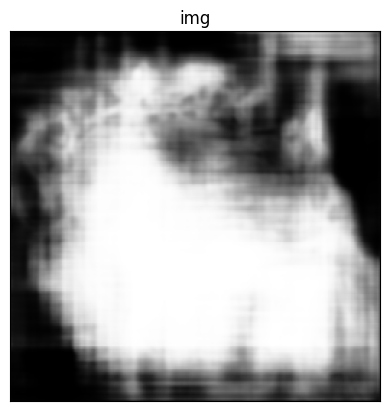

In [ ]:
draw_image(outputs[4])

In [ ]:
inputs, labels = next(iter(train_dataloader))
# inputs = inputs.cuda()
# labels = labels.cuda()
# outputs = model(inputs)
print(inputs.dtype)
print(labels.dtype)

torch.float32
torch.float32


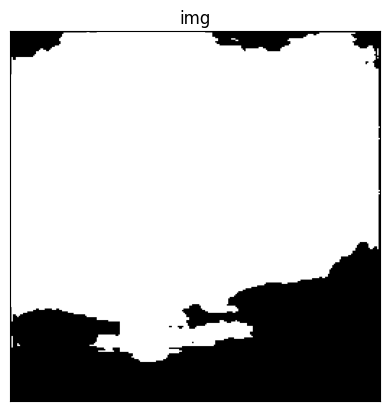

In [ ]:
rounded_outputs = torch.where(outputs > 0.5, 1., 0.).cuda()
draw_image(rounded_outputs[0])

In [ ]:
import torchvision.transforms as transforms
x, y = next(iter(train_dataloader))

a = transforms.RandomHorizontalFlip(1.0)(x)

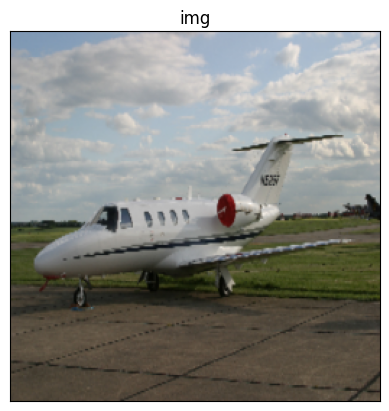

In [ ]:
draw_image(a[1])

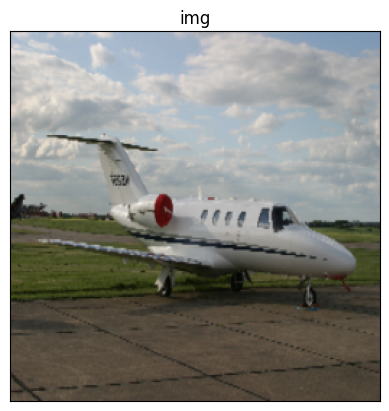

In [ ]:
draw_image(x[1])

In [ ]:
labels.shape

torch.Size([16, 1, 256, 256])

## 3. Challenge Submission
Evaluate on the test set, and save the resulting segmentations in the same format as those in the initial dataset. 
Your challenge results should be saved in a torch file with the same format as in A3, with shape (24, 256, 256), where all values are either 1 (foreground) or 0 (background).

In [26]:
with torch.no_grad():
    model.eval()
    inputs = next(iter(test_dataloader))
    inputs = inputs.cuda()
    test_outputs = model(inputs)
    rounded_test_images = torch.where(test_outputs > 0.5, 1., 0.)
    torch.save(torch.squeeze(rounded_test_images), 'bigmac_results.pth')

Use this code to check your submission file:

In [27]:
masks = torch.load('bigmac_results.pth')

assert(masks.shape == (24, 256, 256))
assert((torch.where(masks == 1, 10, 0).sum() + torch.where(masks == 0, 10, 0).sum()).item() == 24 * 256 * 256 * 10)

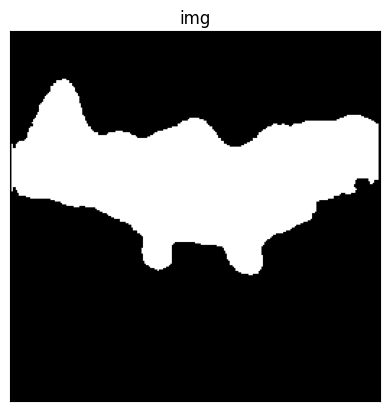

In [28]:
rounded_test_images = torch.where(test_outputs > 0.5, 1., 0.)
draw_image(rounded_test_images[10])

## Analysis



### 4. Plot training and validation loss per batch

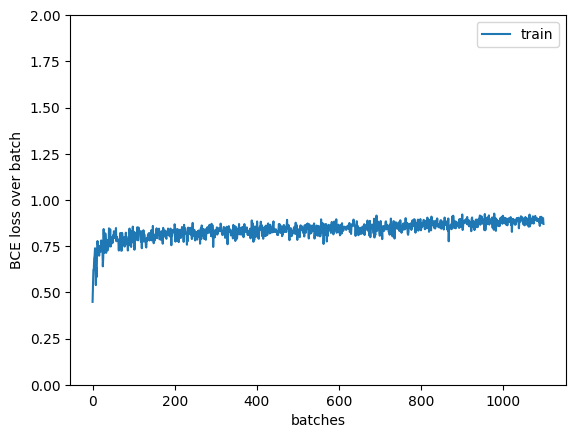

(0.0, 2.0)

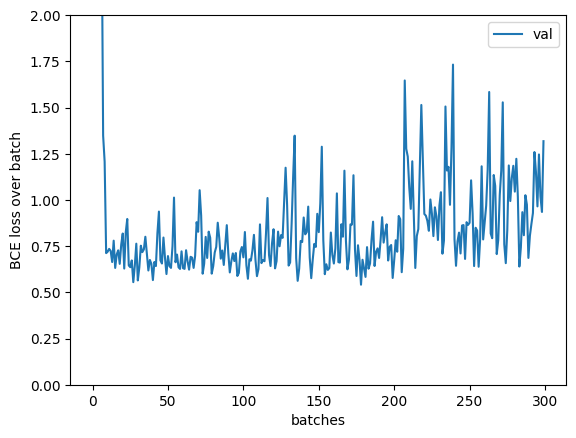

In [36]:
plt.plot(range(len(train_loss_per_batch_across_epochs)), train_loss_per_batch_across_epochs)
plt.xlabel("batches")
plt.ylabel("BCE loss over batch")
plt.legend(["train"])
plt.ylim(0,2)
plt.show()
plt.plot(range(len(val_loss_per_batch_across_epochs)), val_loss_per_batch_across_epochs)
plt.xlabel("batches")
plt.ylabel("BCE loss over batch")
plt.legend(["val"])
plt.ylim(0,2)

### 5. Plot training and validation per-pixel accuracy per epoch

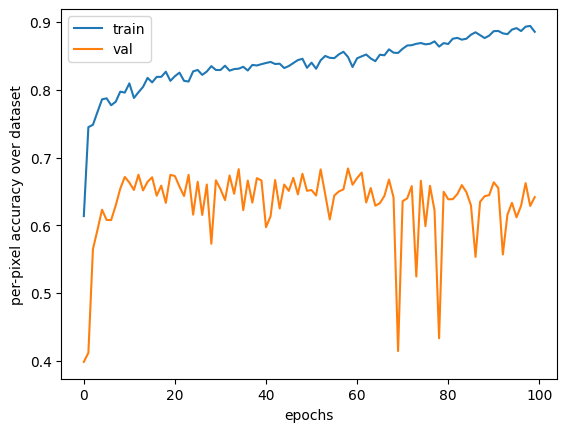

In [24]:
plt.plot(range(len(train_acc_per_epoch)), train_acc_per_epoch)
plt.plot(range(len(val_acc_per_epoch)), val_acc_per_epoch)
plt.xlabel("epochs")
plt.ylabel("per-pixel accuracy over dataset")
plt.legend(["train", "val"])

### 6. Show segmentation result for 3 test images



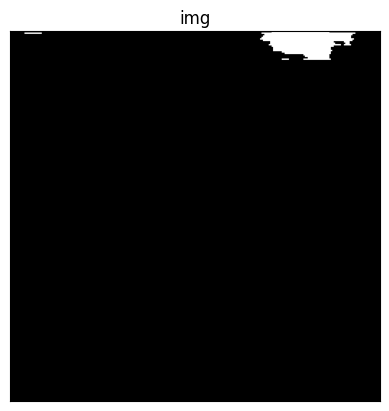

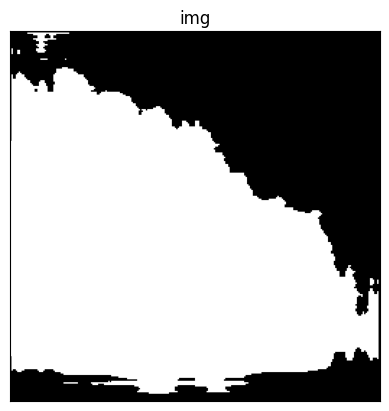

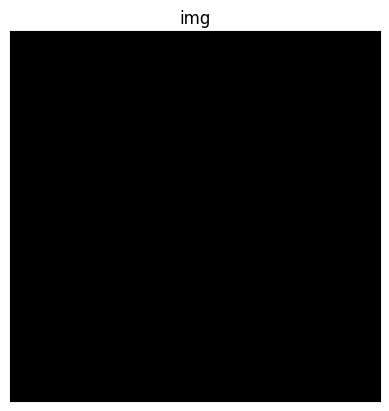

In [29]:
draw_image(rounded_test_images[0])
draw_image(rounded_test_images[1])
draw_image(rounded_test_images[2])